# Project 

## Importing Libraries

In [139]:
import pandas as pd, numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.tree import DecisionTreeRegressor


from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords


from wordcloud import WordCloud, STOPWORDS
#ploting 

import seaborn as sns
import matplotlib.pyplot as plt

## Load Data and Exploratory Data Analysis

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
train['comment_text'][0]

"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"

In [34]:
print('%d Data Features and %d records.' % (train.shape[1], train.shape[0]))


45 Data Features and 1804874 records.


### Estimating NULL values in Dataset

In [5]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' % 
          (perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])
        
check_null(train, train.columns)

0% or 0 missing from id column.
0% or 0 missing from target column.
0% or 0 missing from comment_text column.
0% or 0 missing from severe_toxicity column.
0% or 0 missing from obscene column.
0% or 0 missing from identity_attack column.
0% or 0 missing from insult column.
0% or 0 missing from threat column.
77% or 1399744 missing from asian column.
77% or 1399744 missing from atheist column.
77% or 1399744 missing from bisexual column.
77% or 1399744 missing from black column.
77% or 1399744 missing from buddhist column.
77% or 1399744 missing from christian column.
77% or 1399744 missing from female column.
77% or 1399744 missing from heterosexual column.
77% or 1399744 missing from hindu column.
77% or 1399744 missing from homosexual_gay_or_lesbian column.
77% or 1399744 missing from intellectual_or_learning_disability column.
77% or 1399744 missing from jewish column.
77% or 1399744 missing from latino column.
77% or 1399744 missing from male column.
77% or 1399744 missing from musl

### Getting insights about length of comments

In [8]:


lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()



(297.2343266067327, 269.1966399585543, 1906)

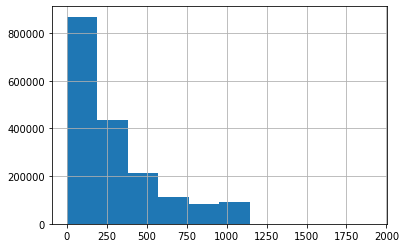

In [13]:
lens.hist();


### How the target value is spreading 

/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


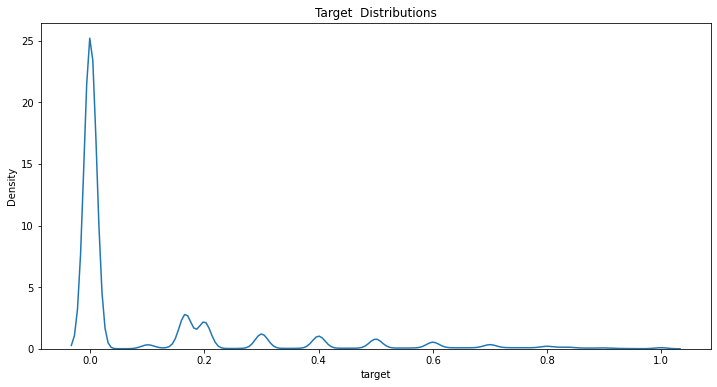

In [26]:


plt.figure(figsize=(12,6))
plt.title("Target  Distributions")
sns.distplot(train['target'], kde=True, hist=False, bins=240, label='target')
plt.show()



### How many comments are toxic 

/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


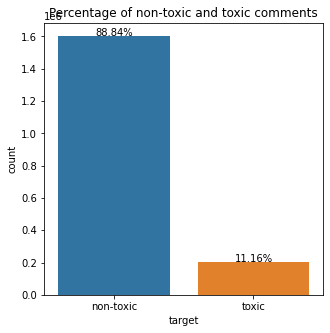

In [28]:
#If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.

temp = train['target'].apply(lambda x: "non-toxic" if x < 0.4 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

### Checking the Correlatins

In [37]:
df = train
targets = list(df.columns[3:8])
df_targets = df[targets].copy()
toxic_rows = df_targets.sum(axis=1)
targets.append('Others')
df_targets['Others'] = toxic_rows
count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts

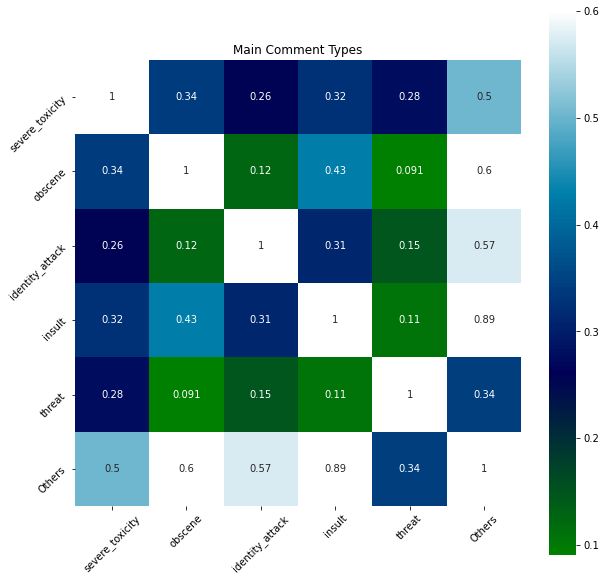

In [52]:
def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    #df_corr = np.triu(df_corr, k=1)
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='ocean')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Main Comment Types')


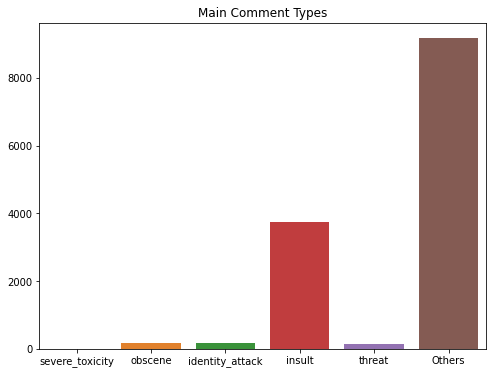

In [46]:

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
       
    

plt.figure('Main Comment Types', figsize=[8,6])
plt.title('Main Comment Types')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

In [53]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

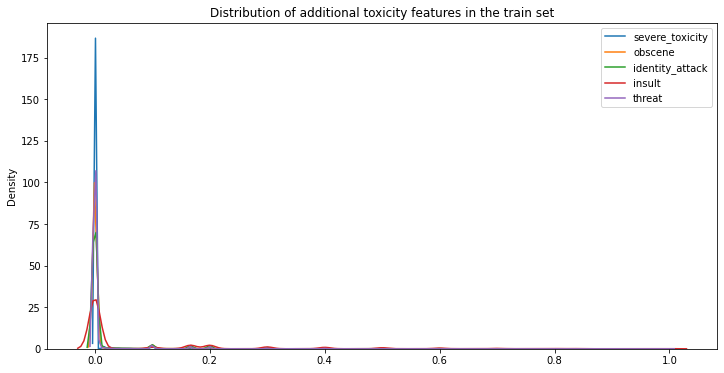

In [55]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train)


/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

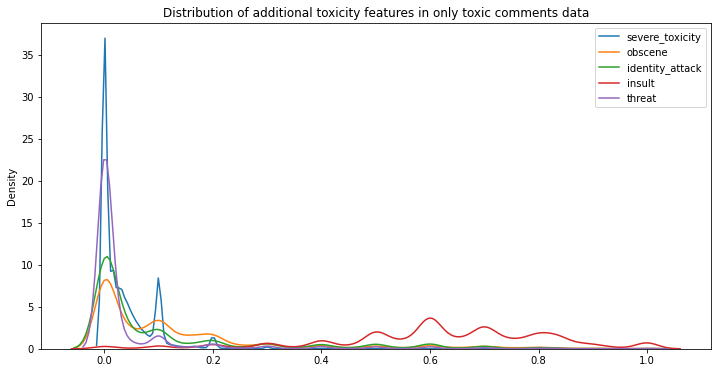

In [57]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train[train['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

In [59]:

# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'



/Users/dev/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


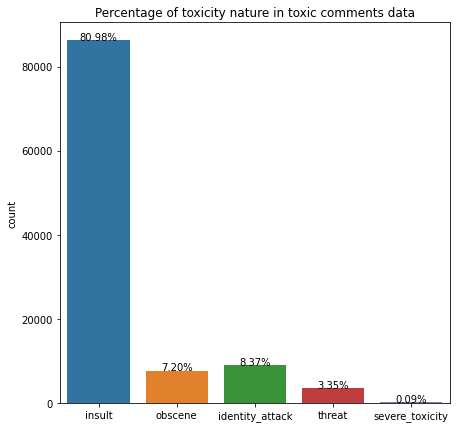

In [61]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

## Processing


In [91]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='wheat',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

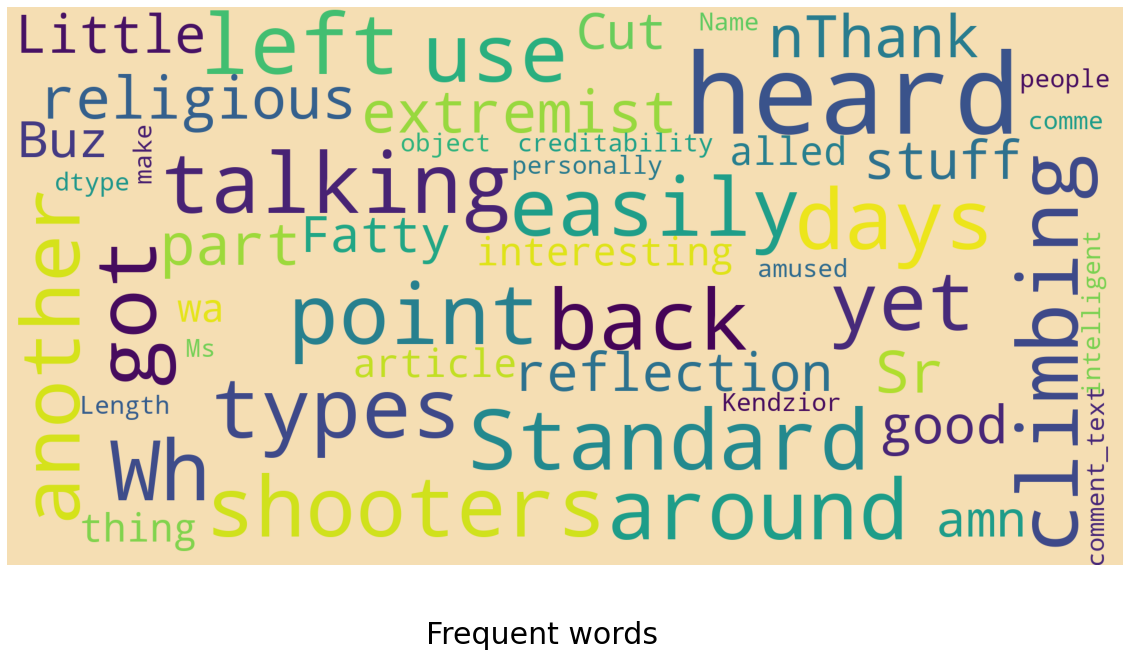

In [89]:
show_wordcloud(train['comment_text'].sample(20000), title = 'Frequent words ')

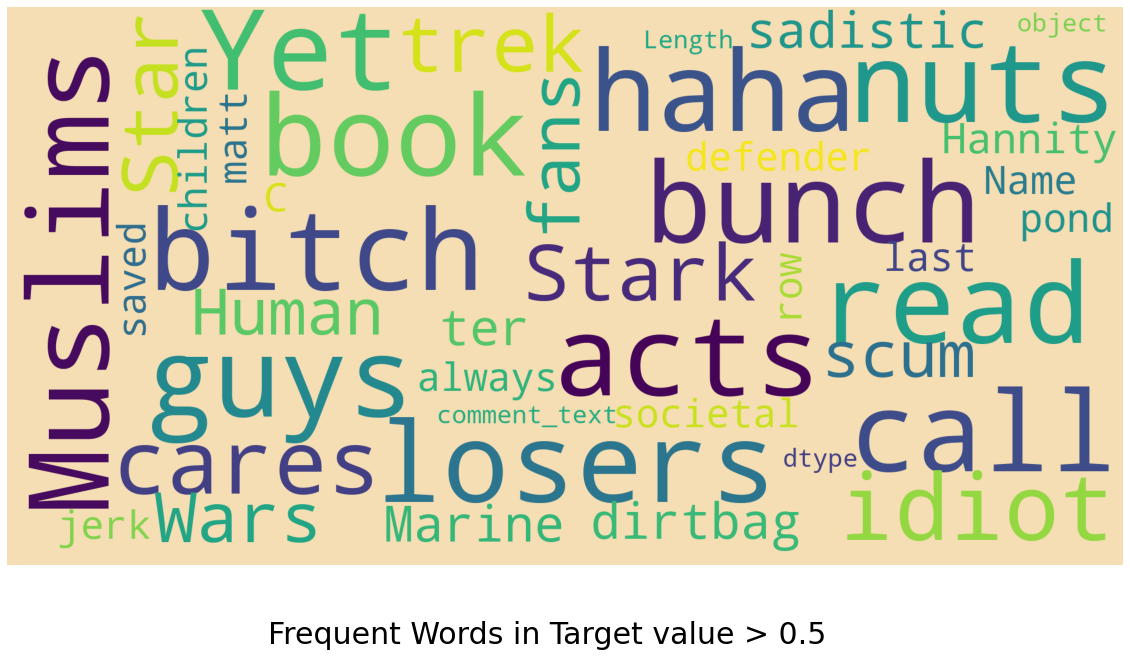

In [92]:
show_wordcloud(train.loc[train['target'] > 0.7]['comment_text'], 
               title = 'Frequent Words in Target value > 0.5')

## NLP 

In [105]:
import nltk 
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [107]:


%%time
train['preprocessed_text'] = train['comment_text'].apply(preprocess)



CPU times: user 11min 8s, sys: 4.02 s, total: 11min 12s
Wall time: 11min 17s


In [108]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [110]:
%%time
test['preprocessed_text'] = test['comment_text'].apply(preprocess)

CPU times: user 34.9 s, sys: 197 ms, total: 35.1 s
Wall time: 35.4 s


In [112]:
feature = train[['preprocessed_text']]
output = train[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)


(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [115]:


X_test = test[['preprocessed_text']]
X_test.head()



,preprocessed_text
0,integr mean pay debt appli presid trump
1,malfeas administr board wast money
2,rmiller101 spoken like true elitist look bud a...
3,paul thank kind word inde strong belief hide b...
4,sorri miss high school eisenhow sent troop vie...


In [116]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

# Training

In [118]:

# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

In [122]:
## BoW

In [125]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)
print("sds")

(1353655, 30000)
(451219, 30000)
(97320, 30000)
sds


### Regression

SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated
to 0.0 to allow for learning sparse models and achieve online feature selection.

In [135]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.6614161737524953
Mean Squared Error on cv set:  0.03668518984932173
**************************************************
1e-05 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.392682101592803
Mean Squared Error on cv set:  0.030409979306425635
**************************************************
0.0001 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.02451580750570673
Mean Squared Error on cv set:  0.02442345276207505
**************************************************
0.0001 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.05330054218146001
Mean Squared Error on cv set:  0.02331075146361765
**************************************************
0.001 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.031452894494108895
Mean Squared Error on cv set:  0.03140733140493191
**************************************************
0.001 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03703552939111816
Mean Squared Error on cv set:  0.023763091864533833
**************************************************
0.01 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03885953940081115
Mean Squared Error on cv set:  0.03877680295082404
**************************************************
0.01 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.028008880039243966
Mean Squared Error on cv set:  0.027911103153446554
**************************************************
0.1 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03885950234725948
Mean Squared Error on cv set:  0.038776915382748335
**************************************************
0.1 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.034912532684567135
Mean Squared Error on cv set:  0.03483407590165844
**************************************************
1 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03885952888453727
Mean Squared Error on cv set:  0.03877698055524834
**************************************************
1 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03816438276289644
Mean Squared Error on cv set:  0.03808094803411207
**************************************************
10 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03885950027391649
Mean Squared Error on cv set:  0.038776908927132564
**************************************************
10 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03879674342496742
Mean Squared Error on cv set:  0.03871410259955765
**************************************************
100 l1 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.03885950022314596
Mean Squared Error on cv set:  0.03877690876373547
**************************************************
100 l2 :


/Users/dev/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error on train set:  0.038851435603865676
Mean Squared Error on cv set:  0.038768643644571395
**************************************************


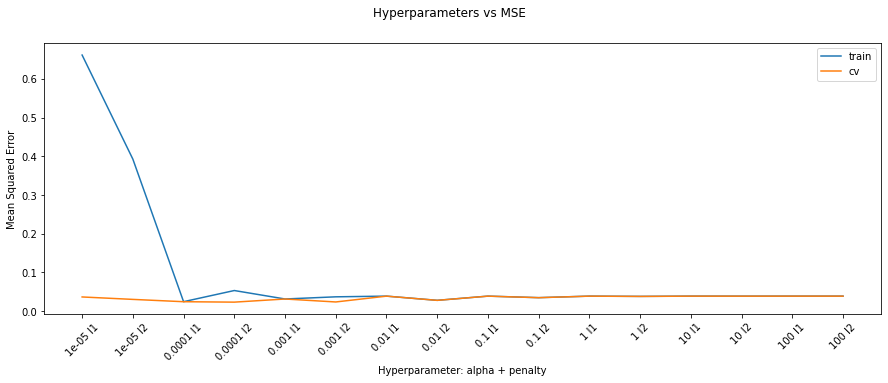

In [136]:


plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()



## Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

For instance, in the example below, decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

In [140]:
#Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03309139001926734
Mean Squared Error on cv set:  0.03315185831174389
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.033091390019267336
Mean Squared Error on cv set:  0.033151858311743866
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03309398205779596
Mean Squared Error on cv set:  0.03315549990854051
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03201180229302478
Mean Squared Error on cv set:  0.03209491911091368
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03201458585120652
Mean Squared Error on cv set:  0.03209085980084973
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on trai

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

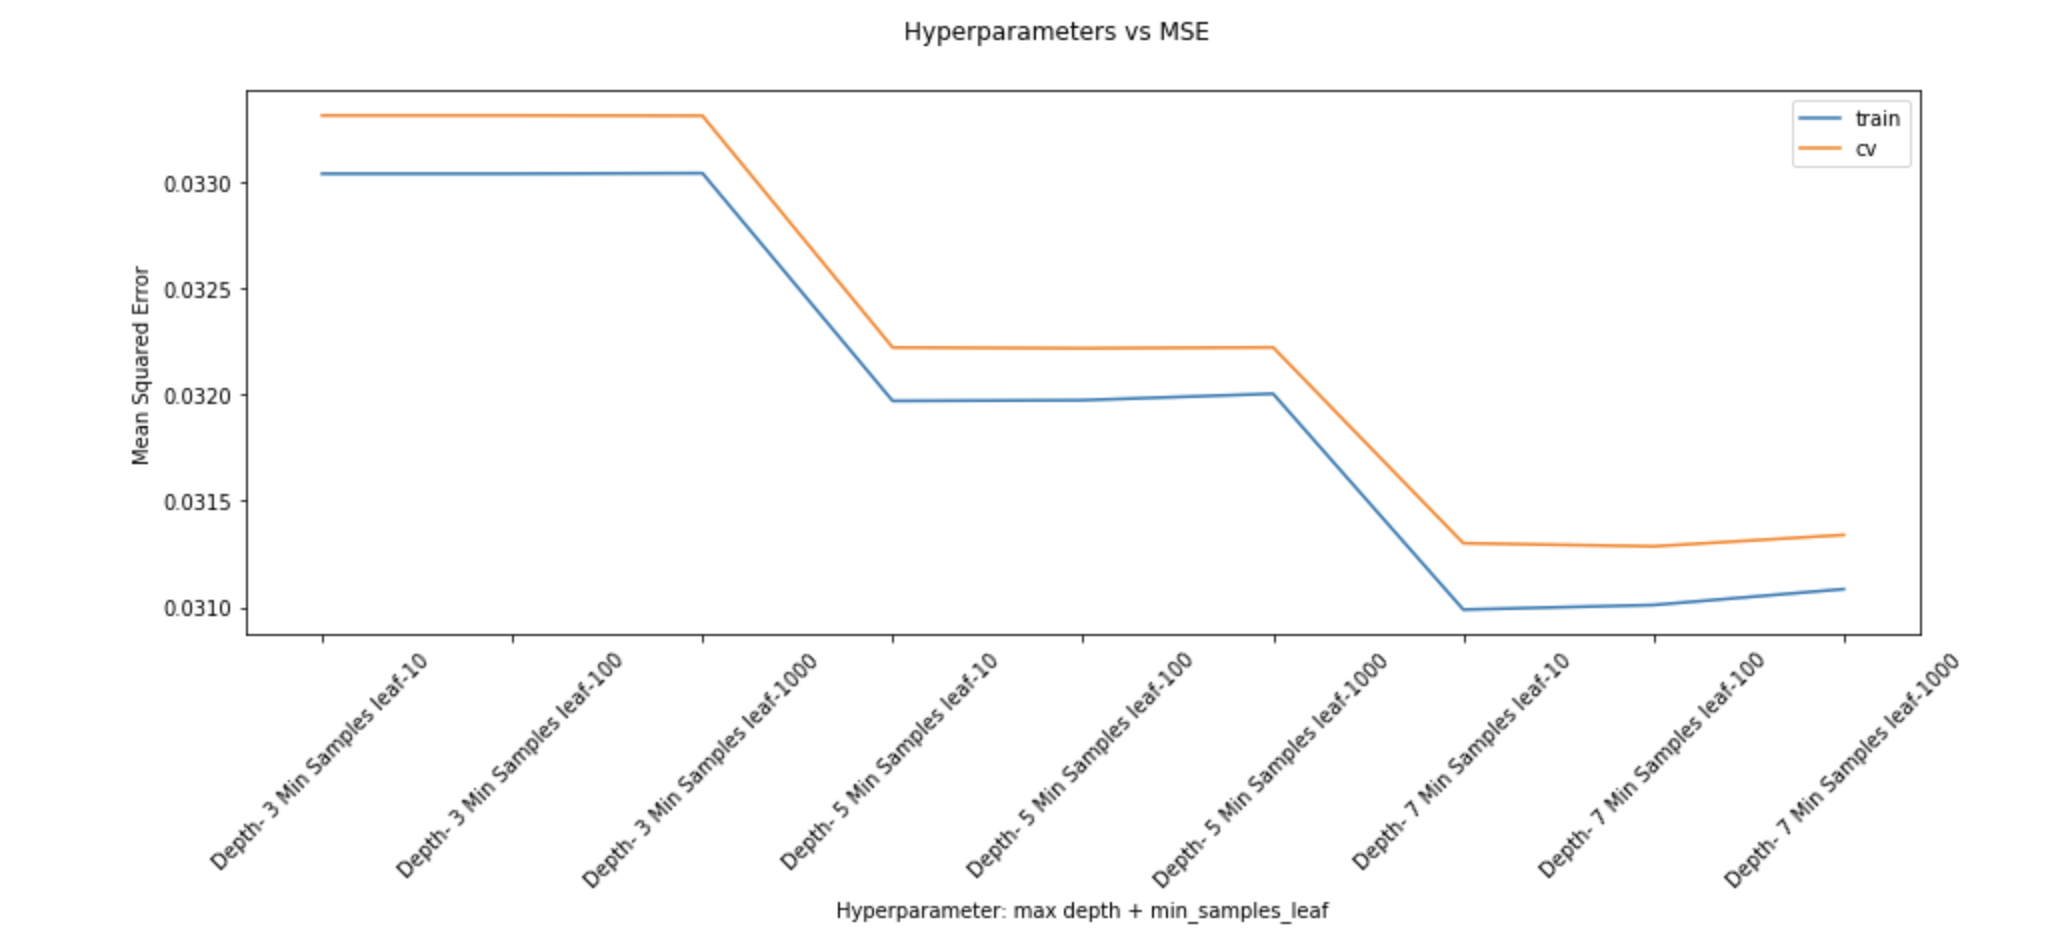

In [ ]:
# Best models parameters:
best_model.get_params()

## LSTM


In [ ]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [ ]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [ ]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train, nb_epoch=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

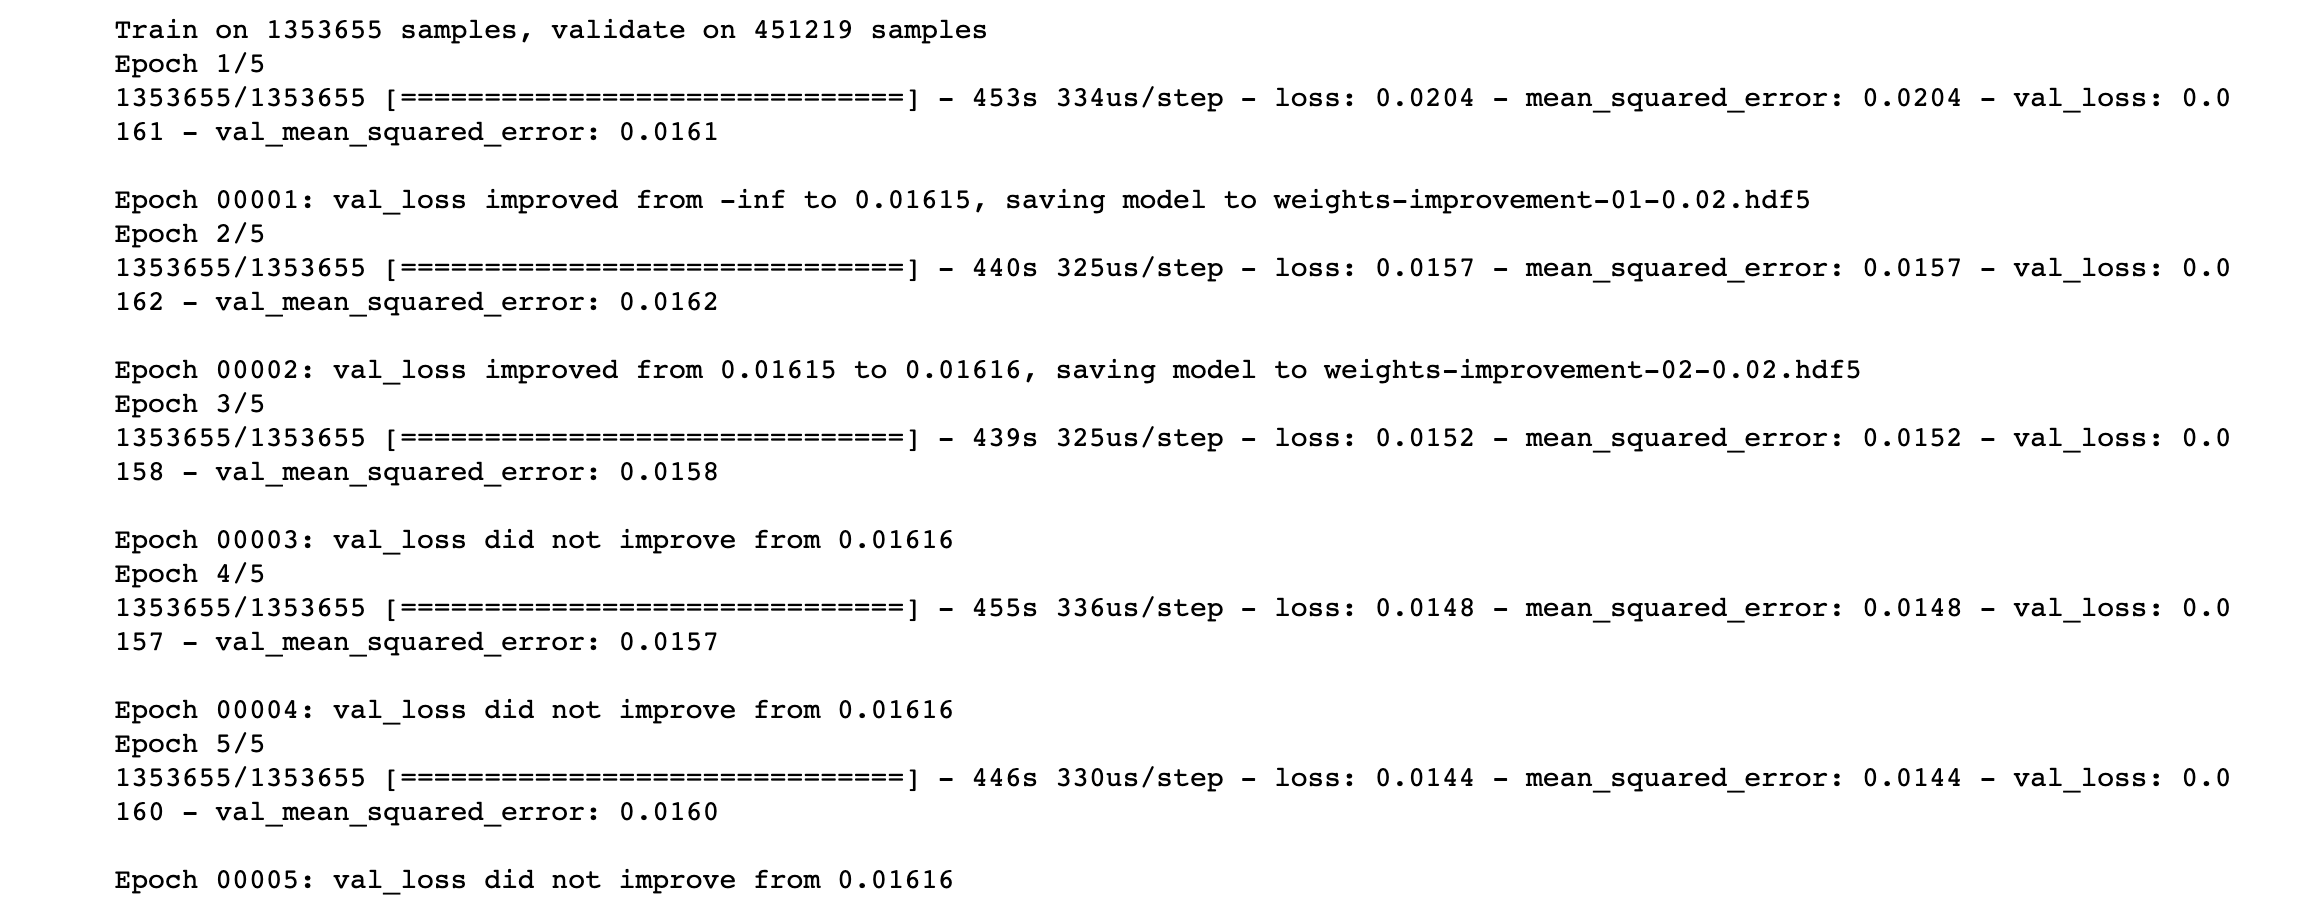

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

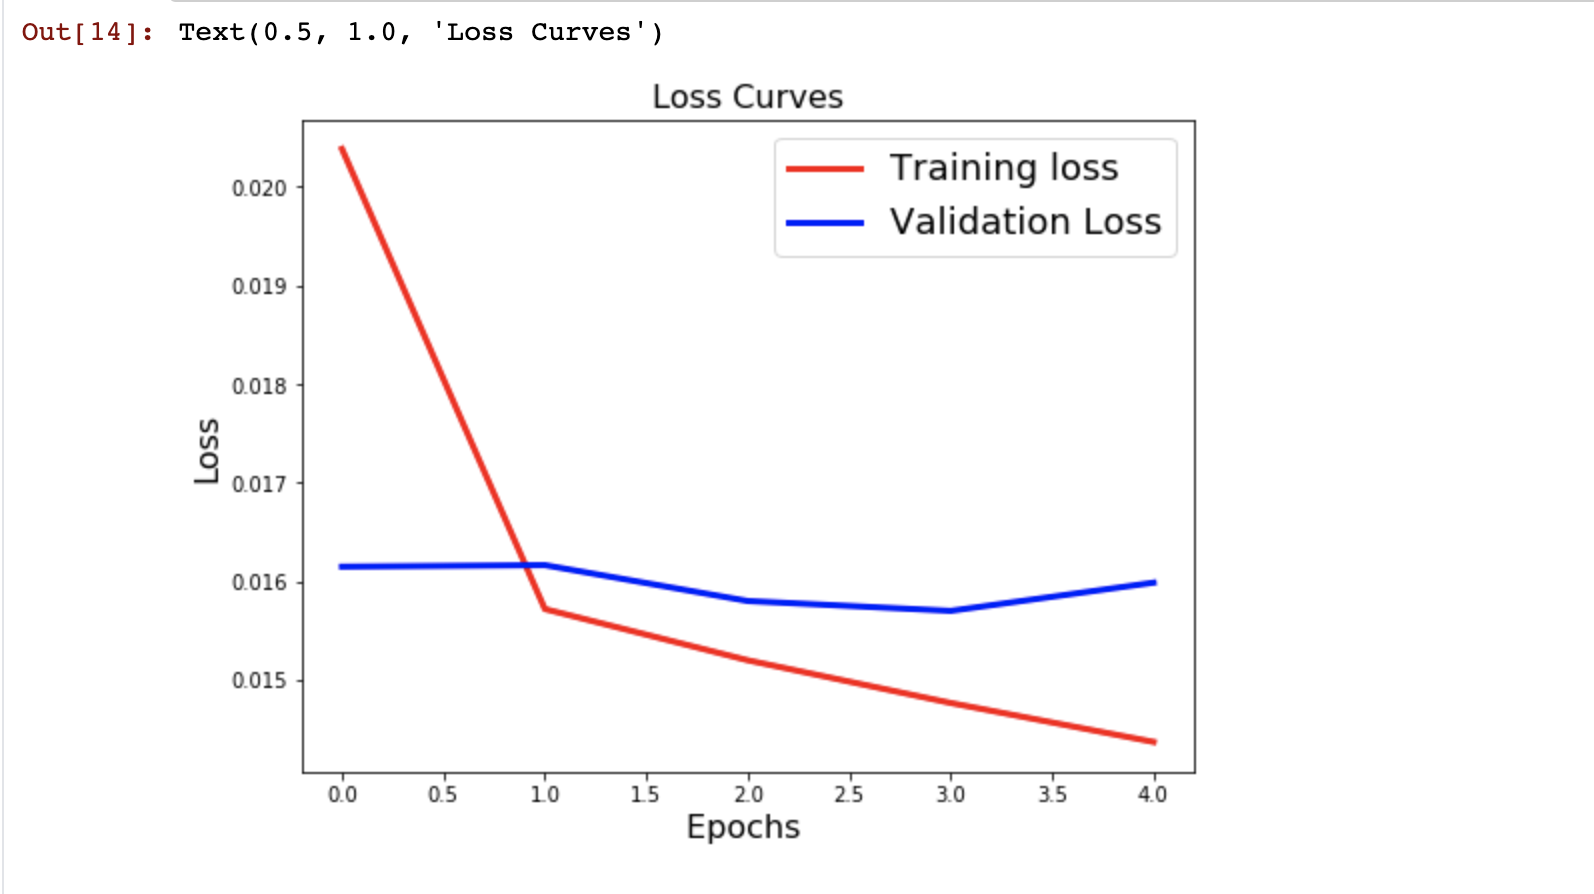